<a href="https://colab.research.google.com/github/sydney-machine-learning/differentiable-pedestrian-simulators/blob/main/Differentiable_pedestrian_simulators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def calc_tau(xi,xj,vi,vj,ri,rj):
  xij=torch.sub(xi,xj)
  vij=torch.sub(vi,vj)
  r=ri+rj
  a=torch.square(torch.linalg.norm(vij, dim=-1, ord=2))
  b=torch.dot(xij,vij)
  c=torch.sub(torch.square(torch.linalg.norm(xij, dim=-1, ord=2)),torch.square(r))
  if torch.square(b)-torch.mul(a,c)<0:
    tau=torch.tensor(float('inf'))
  else:
    nr=-b-torch.sqrt(torch.square(b)-torch.mul(a,c))
    tau=torch.div(nr,a)
    if tau<0:
      tau=torch.tensor(float('inf'))
  return tau


In [ ]:
calc_tau(torch.Tensor([100,21]),torch.Tensor([2,3]),torch.Tensor([1,2]),torch.Tensor([5,4]),torch.Tensor([0]),torch.Tensor([50]))

tensor([12.0962])

In [ ]:
def cont_time_collision(xi,xj,vi,vj,ri,rj,epsilon):
    xij=torch.sub(xi,xj)
    vij=torch.sub(vi,vj)
    r=ri+rj
    xij_hat=-torch.div(xij,torch.linalg.norm(xij,dim=-1,ord=2))
    v_p=torch.dot(vij,xij_hat)
    v_p_vect=v_p*xij_hat
    v_t_vect=torch.sub(vij,v_p_vect)
    v_t=torch.linalg.norm(v_t_vect,dim=-1,ord=2)
    a=torch.tensor([torch.square(torch.linalg.norm(vij))])
    b=torch.tensor([torch.dot(xij,vij)])
    c=torch.sub(torch.square(torch.linalg.norm(xij, dim=-1, ord=2)),torch.square(r))
    sigma=-b+torch.sqrt(torch.square(b)-torch.mul(a,c))
    sigma=torch.div(sigma,c)
    if(sigma < 0 or torch.isnan(sigma)): ## Case of no positive solutions
      sigma=torch.Tensor([0])
    vt_max=torch.div(torch.mul(r,v_p),torch.sqrt(torch.sub(torch.square(torch.linalg.norm(xij,dim=-1,ord=2)),torch.square(r))))
    vt_star=torch.sqrt(torch.sub(torch.tensor([1]),torch.square(epsilon)))
    vt_star=torch.mul(vt_star,vt_max)
    if(v_t<=vt_star):
      sigma1=sigma
    else:
      sigma1=torch.tensor([0])
      sigma1_at_vt_star=torch.mul(torch.add(torch.linalg.norm(xij,dim=-1,ord=2),torch.mul(epsilon,r)),v_p)
      sigma1_at_vt_star=torch.div(sigma1_at_vt_star,torch.sub(torch.square(torch.linalg.norm(xij,dim=-1,ord=2)),torch.square(r)))
      sigma11_at_vt_star=-torch.sqrt(torch.sub(torch.tensor([1]),torch.square(epsilon)))
      sigma11_at_vt_star=torch.div(sigma11_at_vt_star,torch.mul(epsilon,torch.sqrt(torch.sub(torch.square(torch.linalg.norm(xij,dim=-1,ord=2)),torch.square(r)))))
      temp=torch.add(sigma1_at_vt_star,torch.mul(sigma11_at_vt_star,torch.sub(v_t,vt_star)))
      if(temp>sigma1):
        sigma1=temp
    return sigma1

In [ ]:
print(cont_time_collision(torch.Tensor([100,21]),torch.Tensor([2,3]),torch.Tensor([1,2]),torch.Tensor([5,4]),torch.Tensor([0]),torch.Tensor([50]),torch.Tensor([0.03])))

tensor([0.0827])


In [ ]:
def plot(): # A plot between tuning parameter epsilon and inv_time
  x=np.linspace(0,1,100)
  y=[]
  for val in x:
    ans=cont_time_collision(torch.Tensor([100,21]),torch.Tensor([2,3]),torch.Tensor([1,2]),torch.Tensor([5,4]),torch.Tensor([0]),torch.Tensor([50]),torch.Tensor([val]))
    ans=ans.tolist()
    y.append(ans)
  plt.plot(x,y)
  plt.xlabel("Different values of epsilon")
  plt.ylabel("Sigma")
  plt.show()

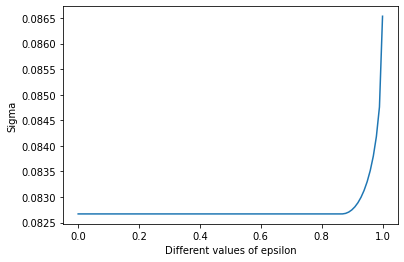

In [ ]:
plot()

In [ ]:
def trajectory(x1,x2,v1,v2,r1,r2,epsilon,delta,k,p,time,tau_0,eta):
    
    vi_1=torch.rand(2,requires_grad=True)
    vi_2=torch.rand(2,requires_grad=True)
    x1_traj=[]
    x2_traj=[]
    x1_traj.append(x1.tolist())
    x2_traj.append(x2.tolist())
    adam=torch.optim.Adam(params=[vi_1,vi_2])
    x_curr1=x1
    x_curr2=x2
    mag_v1=torch.linalg.norm(v1)
    mag_v2=torch.linalg.norm(v2)
    for j in range(100):

      x1_hat=torch.div(torch.sub(x2,x_curr1),torch.linalg.norm(torch.sub(x_curr1,x2)))
      #mag_v1=torch.linalg.norm(v1)
      #mag_v2=torch.linalg.norm(v2)
      vig_1=torch.mul(mag_v1,x1_hat)
      x2_hat=torch.div(torch.sub(x1,x_curr2),torch.linalg.norm(torch.sub(x_curr2,x1)))
      vig_2=torch.mul(mag_v2,x2_hat)
      for i in range(100):
        #loss_fn=torch.mul(torch.Tensor([0.5]),torch.mul(delta,torch.square(torch.linalg.norm(torch.sub(vi_1,vig_1),dim=-1,ord=2))))
        loss_fn=torch.mul(torch.Tensor([0.5]),torch.mul(delta,torch.square(torch.linalg.norm(torch.sub(vi_1,vig_1)))))
        loss_fn=torch.add(loss_fn,torch.mul(torch.Tensor([0.5]),torch.mul(delta,torch.square(torch.linalg.norm(torch.sub(vi_2,vig_2))))))
        sigma=cont_time_collision(x1,x2,vi_1,vi_2,r1,r2,epsilon)
        r=r1+r2
        xij=torch.sub(x1,x2)
        if(torch.linalg.norm(xij)>r):
          u_term=torch.div(eta,torch.sub(torch.linalg.norm(xij),r))
        else:
          u_term=torch.tensor(float('inf'))
        potential_term=torch.exp(-(torch.div(torch.Tensor(1),torch.mul(sigma,tau_0))))
        potential_term=torch.mul(k,torch.mul(potential_term,torch.pow(sigma,p)))
        loss_fn=torch.add(loss_fn,potential_term)
        loss_fn=torch.add(loss_fn,u_term)
        adam.zero_grad()
        loss_fn.backward(retain_graph=True)
        adam.step()

      x_curr1=torch.mul(vi_1,time)
      x_curr2=torch.mul(vi_2,time)
      x1_traj.append(x_curr1.tolist())
      x2_traj.append(x_curr2.tolist())

      
      
    

    return x1_traj,x2_traj


    









In [ ]:
x,y=trajectory(torch.Tensor([0,0]),torch.Tensor([1,0]),torch.Tensor([1,0]),torch.Tensor([-1,0]),torch.Tensor([0.01]),torch.Tensor([0.01]),torch.Tensor([0.2]),torch.Tensor([2]),torch.Tensor([2]),torch.Tensor([2]),torch.Tensor([0.02]),torch.Tensor([3]),torch.Tensor([0.01]))

In [ ]:
x

[[0.0, 0.0],
 [0.012116895988583565, 0.007527044974267483],
 [0.013826937414705753, 0.005785208195447922],
 [0.015303228981792927, 0.004309921059757471],
 [0.01654009148478508, 0.003098295768722892],
 [0.017486056312918663, 0.0023931865580379963],
 [0.018019987270236015, 0.002802076982334256],
 [0.018333859741687775, 0.0034796399995684624],
 [0.018497265875339508, 0.004200252704322338],
 [0.018841596320271492, 0.0036054744850844145],
 [0.01883714832365513, 0.004230762366205454],
 [0.019110023975372314, 0.0033896092791110277],
 [0.018957797437906265, 0.004241309594362974],
 [0.019437234848737717, 0.002387046115472913],
 [0.0193565022200346, 0.0025763073936104774],
 [0.018780922517180443, 0.0046890233643352985],
 [0.01938791386783123, 0.0029316770378500223],
 [0.018967533484101295, 0.0040138172917068005],
 [0.018429551273584366, 0.0058257137425243855],
 [0.019314508885145187, 0.0037187011912465096],
 [0.018822383135557175, 0.0045987400226294994],
 [0.019507581368088722, 0.003033321117982

In [ ]:
y

[[1.0, 0.0],
 [0.011520973406732082, 0.0007294872193597257],
 [0.00959890615195036, -6.695889169350266e-05],
 [0.00773771945387125, 7.258826826728182e-06],
 [0.005936505738645792, -1.0476541092430125e-06],
 [0.004206361249089241, -0.0005374661996029317],
 [0.0025903177447617054, -0.0005754106678068638],
 [0.0010595275089144707, -0.000295858655590564],
 [-0.00039140263106673956, 7.768144132569432e-05],
 [0.001056546694599092, -0.0003349329927004874],
 [-0.00020955914806108922, 7.203199493233114e-05],
 [0.0013500457862392068, -0.0005580149590969086],
 [2.3886115741333924e-05, 0.00010985583503497764],
 [-0.001340370625257492, -0.006367469672113657],
 [-0.0008399537764489651, -0.0017770305275917053],
 [0.00024934150860644877, 0.0006902303430251777],
 [-0.000647607957944274, -0.0022803342435508966],
 [5.635328079733881e-07, -8.46338807605207e-05],
 [-4.1577550291549414e-06, 0.0018717303173616529],
 [5.0580219976836815e-06, -0.001194814802147448],
 [8.353587327292189e-05, 0.00056006957311183

In [ ]:
x1_val=[]
y1_val=[]
for item in x:
  x1_val.append(item[0])
  y1_val.append(item[1])
x2_val=[]
y2_val=[]
for item in y:
  x2_val.append(item[0])
  y2_val.append(item[1])

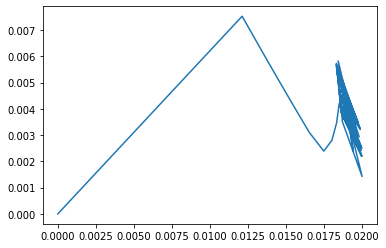

In [ ]:
plt.plot(x1_val,y1_val)

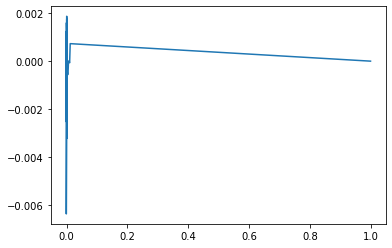

In [ ]:
plt.plot(x2_val,y2_val)